In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh
from scipy.interpolate import interp1d


### Основной класс

In [2]:
class QuantumWellSolver:
    """
    Решатель уравнения Шредингера для произвольной потенциальной ямы
    """
    
    def __init__(self, a=1e-9, N=1000):
        """
        Инициализация решателя
        
        Parameters:
        a - ширина расчетной области [м]
        N - количество точек сетки
        """
        # Физические константы
        self.hbar = 1.0545718e-34        # ℏ [Дж·с]
        self.m = 9.1093837e-31           # масса электрона [кг]
        self.eV_to_J = 1.6021766e-19     # коэффициент перевода эВ в Дж
        
        # Параметры сетки
        self.a = a
        self.N = N
        self.x = np.linspace(0, a, N)
        self.dx = self.x[1] - self.x[0]
        
        # Потенциал и результаты
        self.U = None
        self.eigenvalues = None
        self.eigenvectors = None
        self.bound_energies = None
        self.bound_states = None
        self.wavenumbers_info = None
    
    def set_potential(self, potential_type, **params):
        """
        Задание потенциальной ямы
        
        Parameters:
        potential_type - тип потенциала: 'arbitrary', 'rectangular', 'parabolic', 'triangular', 'double_well'
        **params - параметры потенциала
        """
        if potential_type == 'arbitrary':
            # Произвольный потенциал, заданный функцией
            if 'function' not in params:
                raise ValueError("Для произвольного потенциала необходимо задать function")
            self.U = params['function'](self.x)
            
        elif potential_type == 'rectangular':
            # Прямоугольная яма (совместимость с исходным кодом)
            U_eV = params.get('U_eV', 10.0)
            left_bound = params.get('left_bound', 0.2)
            right_bound = params.get('right_bound', 0.8)
            
            U_J = U_eV * self.eV_to_J
            self.U = np.zeros(self.N)
            inside_well = (self.x > left_bound * self.a) & (self.x < right_bound * self.a)
            self.U[inside_well] = -U_J
            
        elif potential_type == 'parabolic':
            # Параболическая яма
            U_eV = params.get('U_eV', 10.0)
            U_J = U_eV * self.eV_to_J
            center = self.a / 2
            width = params.get('width', 0.6 * self.a)
            
            # U(x) = -U0 * (1 - ((x - center)/(width/2))^2) внутри ямы
            self.U = np.zeros(self.N)
            inside_well = (self.x > center - width/2) & (self.x < center + width/2)
            x_centered = self.x[inside_well] - center
            self.U[inside_well] = -U_J * (1 - (x_centered / (width/2))**2)
            
        elif potential_type == 'triangular':
            # Треугольная яма
            U_eV = params.get('U_eV', 10.0)
            U_J = U_eV * self.eV_to_J
            left = params.get('left', 0.3 * self.a)
            right = params.get('right', 0.7 * self.a)
            
            self.U = np.zeros(self.N)
            # Линейный спуск и подъем
            mask_descend = (self.x >= left) & (self.x <= (left + right)/2)
            mask_ascend = (self.x > (left + right)/2) & (self.x <= right)
            
            if np.any(mask_descend):
                x_descend = self.x[mask_descend]
                self.U[mask_descend] = -U_J * (x_descend - left) / ((right - left)/2)
            
            if np.any(mask_ascend):
                x_ascend = self.x[mask_ascend]
                self.U[mask_ascend] = -U_J * (right - x_ascend) / ((right - left)/2)
                
        elif potential_type == 'double_well':
            # Двойная яма
            U_eV = params.get('U_eV', 10.0)
            U_J = U_eV * self.eV_to_J
            well_width = params.get('well_width', 0.2 * self.a)
            barrier_width = params.get('barrier_width', 0.1 * self.a)
            
            self.U = np.zeros(self.N)
            # Первая яма
            well1_left = 0.2 * self.a
            well1_right = well1_left + well_width
            well1_mask = (self.x > well1_left) & (self.x < well1_right)
            self.U[well1_mask] = -U_J
            
            # Вторая яма
            well2_left = well1_right + barrier_width
            well2_right = well2_left + well_width
            well2_mask = (self.x > well2_left) & (self.x < well2_right)
            self.U[well2_mask] = -U_J
            
        elif potential_type == 'table':
            # Потенциал, заданный таблично
            if 'x_table' not in params or 'U_table' not in params:
                raise ValueError("Для табличного потенциала необходимо задать x_table и U_table")
            
            x_table = params['x_table']
            U_table = params['U_table']
            
            # Интерполяция на расчетную сетку
            interp_func = interp1d(x_table, U_table, kind='linear', 
                                 bounds_error=False, fill_value=0.0)
            self.U = interp_func(self.x)
            
        else:
            raise ValueError(f"Неизвестный тип потенциала: {potential_type}")
    
    def solve(self):
        """Решение уравнения Шредингера"""
        if self.U is None:
            raise ValueError("Потенциал не задан. Используйте set_potential()")
        
        # Коэффициент для кинетической энергии
        k_coeff = self.hbar**2 / (2 * self.m * self.dx**2)
        
        # Построение матрицы Гамильтониана
        H = np.zeros((self.N, self.N))
        np.fill_diagonal(H, 2 * k_coeff + self.U)
        
        for i in range(self.N-1):
            H[i, i+1] = -k_coeff
            H[i+1, i] = -k_coeff
        
        # Решение задачи на собственные значения
        self.eigenvalues, self.eigenvectors = eigh(H)
        
        # Перевод энергий в эВ и поиск связанных состояний
        energies_eV = self.eigenvalues / self.eV_to_J
        bound_mask = energies_eV < 0
        self.bound_energies = energies_eV[bound_mask]
        self.bound_states = self.eigenvectors[:, bound_mask]
        
        # Нормировка волновых функций
        for i in range(self.bound_states.shape[1]):
            psi = self.bound_states[:, i]
            norm = np.sqrt(np.trapezoid(np.abs(psi)**2, self.x))
            self.bound_states[:, i] = psi / norm
        
        # Вычисление волновых чисел
        self._compute_wavenumbers()
    
    def _compute_wavenumbers(self):
        """Вычисление волновых чисел для связанных состояний"""
        if self.bound_energies is None:
            return
        
        self.wavenumbers_info = []
        
        for i, energy_eV in enumerate(self.bound_energies):
            energy_J = energy_eV * self.eV_to_J
            
            # Волновые числа (приближенно, используя минимальный потенциал как точку отсчета)
            U_min = np.min(self.U)
            k_inside = np.sqrt(2 * self.m * (energy_J - U_min)) / self.hbar
            k_outside = np.sqrt(-2 * self.m * energy_J) / self.hbar
            
            # Длина волны и глубина проникновения
            wavelength = 2 * np.pi / k_inside
            penetration_depth = 1.0 / k_outside
            
            # Анализ узлов
            psi = self.bound_states[:, i]
            zero_crossings = len(np.where(np.diff(np.sign(psi)))[0])
            
            self.wavenumbers_info.append({
                'k_inside': k_inside,
                'k_outside': k_outside,
                'wavelength': wavelength,
                'penetration_depth': penetration_depth,
                'nodes': zero_crossings
            })
    
    def analyze_states(self, max_states=9999):
        """Анализ связанных состояний"""
        if self.bound_energies is None:
            raise ValueError("Сначала выполните solve()")
        
        print(f"Найдено {len(self.bound_energies)} связанных состояний")
        print("Энергии связанных состояний (в эВ):")
        
        for n, energy in enumerate(self.bound_energies[:max_states]):
            if self.wavenumbers_info and n < len(self.wavenumbers_info):
                info = self.wavenumbers_info[n]
                print(f"E_{n+1} = {energy:.4f} эВ, узлов: {info['nodes']}")
                print(f"  k (внутри) = {info['k_inside']*1e-9:.4f} 1/нм, κ (снаружи) = {info['k_outside']*1e-9:.4f} 1/нм")
                print(f"  λ = {info['wavelength']*1e9:.2f} нм, глубина проникновения = {info['penetration_depth']*1e9:.2f} нм")
            else:
                print(f"E_{n+1} = {energy:.4f} эВ")
            print()
    
    def plot_potential_with_wavefunctions(self, max_states=9999):
        """
        Основной график: потенциальная яма с наложенными волновыми функциями
        и информацией о волновых числах
        """
        if self.bound_energies is None:
            raise ValueError("Сначала выполните solve()")
        
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))
        
        colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']
        
        # Определяем масштаб для волновых функций
        U_min = np.min(self.U / self.eV_to_J)
        energy_range = abs(U_min) if U_min < 0 else 1
        wavefunction_scale = 0.15 * energy_range
        
        # Верхний график: потенциал и волновые функции
        ax1.plot(self.x * 1e9, self.U / self.eV_to_J, 'k-', linewidth=3, 
                label='Потенциал U(x)', alpha=0.7)
        
        # Рисуем энергетические уровни
        for i, energy in enumerate(self.bound_energies[:max_states]):
            ax1.axhline(y=energy, color=colors[i % len(colors)], 
                       linestyle='--', alpha=0.6, linewidth=1)
        
        # Рисуем волновые функции с правильным масштабированием
        for i in range(min(max_states, len(self.bound_energies))):
            psi = self.bound_states[:, i]
            
            # Масштабируем волновую функцию для визуализации
            max_amplitude = np.max(np.abs(psi))
            if max_amplitude > 0:
                scaled_psi = psi * (wavefunction_scale / max_amplitude)
            else:
                scaled_psi = psi
            
            ax1.plot(self.x * 1e9, scaled_psi + self.bound_energies[i], 
                   color=colors[i % len(colors)], linewidth=2.5,
                   label=f'ψ_{i+1} (E={self.bound_energies[i]:.3f} эВ)')
            
            # Заполняем область под волновой функцией
            ax1.fill_between(self.x * 1e9, self.bound_energies[i], 
                           scaled_psi + self.bound_energies[i],
                           color=colors[i % len(colors)], alpha=0.2)
        
        ax1.set_xlabel('x [нм]', fontsize=12)
        ax1.set_ylabel('Энергия [эВ]', fontsize=12)
        ax1.set_title('Потенциальная яма и волновые функции связанных состояний', fontsize=14)
        ax1.legend(fontsize=10)
        ax1.grid(True, alpha=0.3)
        
        # Нижний график: плотности вероятности
        probability_scale = 0.2 * energy_range
        
        ax2.plot(self.x * 1e9, self.U / self.eV_to_J, 'k-', linewidth=2, 
                label='Потенциал U(x)', alpha=0.7)
        
        for i in range(min(max_states, len(self.bound_energies))):
            probability = np.abs(self.bound_states[:, i])**2
            
            # Масштабируем плотность вероятности
            max_prob = np.max(probability)
            if max_prob > 0:
                scaled_prob = probability * (probability_scale / max_prob)
            else:
                scaled_prob = probability
            
            ax2.plot(self.x * 1e9, scaled_prob + self.bound_energies[i],
                   color=colors[i % len(colors)], linewidth=2,
                   label=f'|ψ_{i+1}|²')
            
            ax2.fill_between(self.x * 1e9, self.bound_energies[i],
                           scaled_prob + self.bound_energies[i],
                           color=colors[i % len(colors)], alpha=0.3)
        
        ax2.set_xlabel('x [нм]', fontsize=12)
        ax2.set_ylabel('Энергия [эВ]', fontsize=12)
        ax2.set_title('Плотности вероятности', fontsize=14)
        ax2.legend(fontsize=10)
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        # Добавляем информацию о волновых числах
        if self.wavenumbers_info:
            text_lines = ["Волновые числа связанных состояний:"]
            for i in range(min(max_states, len(self.wavenumbers_info))):
                info = self.wavenumbers_info[i]
                energy = self.bound_energies[i]
                text_lines.append(f"E_{i+1} = {energy:.3f} эВ:")
                text_lines.append(f"  k = {info['k_inside']*1e-9:.3f} 1/нм, κ = {info['k_outside']*1e-9:.3f} 1/нм")
                text_lines.append(f"  λ = {info['wavelength']*1e9:.2f} нм, d = {info['penetration_depth']*1e9:.2f} нм")
                text_lines.append("")
            
            text = "\n".join(text_lines)
            fig.text(0.02, 0.02, text, fontsize=9, family='monospace',
                    bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8),
                    verticalalignment='bottom')
        
        plt.show()


### Примеры ям

In [3]:
def rectangular_well():
    """Пример: прямоугольная яма (совместимость с исходным кодом)"""
    print("=== ПРЯМОУГОЛЬНАЯ ЯМА ===")
    
    solver = QuantumWellSolver(a=1e-9, N=1000)
    solver.set_potential('rectangular', U_eV=10.0, left_bound=0.2, right_bound=0.8)
    solver.solve()
    solver.analyze_states()
    solver.plot_potential_with_wavefunctions()
    
    return solver

def parabolic_well():
    """Пример: параболическая яма"""
    print("=== ПАРАБОЛИЧЕСКАЯ ЯМА ===")
    
    solver = QuantumWellSolver(a=1e-9, N=1000)
    solver.set_potential('parabolic', U_eV=15.0, width=0.6e-9)
    solver.solve()
    solver.analyze_states()
    solver.plot_potential_with_wavefunctions()
    
    return solver

def double_well():
    """Пример: двойная яма"""
    print("=== ДВОЙНАЯ ЯМА ===")
    
    solver = QuantumWellSolver(a=1e-9, N=1000)
    solver.set_potential('double_well', U_eV=8.0, well_width=0.15e-9, barrier_width=0.1e-9)
    solver.solve()
    solver.analyze_states()
    solver.plot_potential_with_wavefunctions()
    
    return solver

def table_well():
    """Пример: потенциал, заданный таблично"""
    print("=== ТАБЛИЧНЫЙ ПОТЕНЦИАЛ ===")
    
    # Задаем потенциал таблично
    x_table = np.array([0, 0.2, 0.3, 0.5, 0.7, 0.8, 1.0]) * 1e-9
    U_table_eV = np.array([0, 0, -12, -15, -12, 0, 0])  # эВ
    U_table = U_table_eV * 1.6021766e-19  # перевод в Дж
    
    solver = QuantumWellSolver(a=1e-9, N=1000)
    solver.set_potential('table', x_table=x_table, U_table=U_table)
    solver.solve()
    solver.analyze_states()
    solver.plot_potential_with_wavefunctions()
    
    return solver

def arbitrary_well():
    """Пример: произвольная яма с аналитической функцией"""
    print("=== ПРОИЗВОЛЬНАЯ ЯМА (аналитическая) ===")
    
    def custom_potential(x):
        """Пример сложного потенциала: яма с барьером"""
        a = x[-1]  # ширина области
        U = np.zeros_like(x)
        
        # Основная яма
        main_well = (x > 0.2*a) & (x < 0.5*a)
        U[main_well] = -10 * 1.6021766e-19  # -10 эВ
        
        # Барьер
        barrier = (x > 0.5*a) & (x < 0.6*a)
        U[barrier] = -2 * 1.6021766e-19  # -2 эВ
        
        # Вторая яма
        second_well = (x > 0.6*a) & (x < 0.9*a)
        U[second_well] = -9 * 1.6021766e-19  # -8 эВ
        
        return U
    
    solver = QuantumWellSolver(a=1e-9, N=1000)
    solver.set_potential('arbitrary', function=custom_potential)
    solver.solve()
    solver.analyze_states()
    solver.plot_potential_with_wavefunctions()
    
    return solver


### Выбор и выполнение конкретного случая

=== ПРЯМОУГОЛЬНАЯ ЯМА ===
Найдено 3 связанных состояний
Энергии связанных состояний (в эВ):
E_1 = -9.2848 эВ, узлов: 0
  k (внутри) = 4.3325 1/нм, κ (снаружи) = 15.6108 1/нм
  λ = 1.45 нм, глубина проникновения = 0.06 нм

E_2 = -7.1768 эВ, узлов: 1
  k (внутри) = 8.6081 1/нм, κ (снаружи) = 13.7247 1/нм
  λ = 0.73 нм, глубина проникновения = 0.07 нм

E_3 = -3.8182 эВ, узлов: 2
  k (внутри) = 12.7379 1/нм, κ (снаружи) = 10.0108 1/нм
  λ = 0.49 нм, глубина проникновения = 0.10 нм



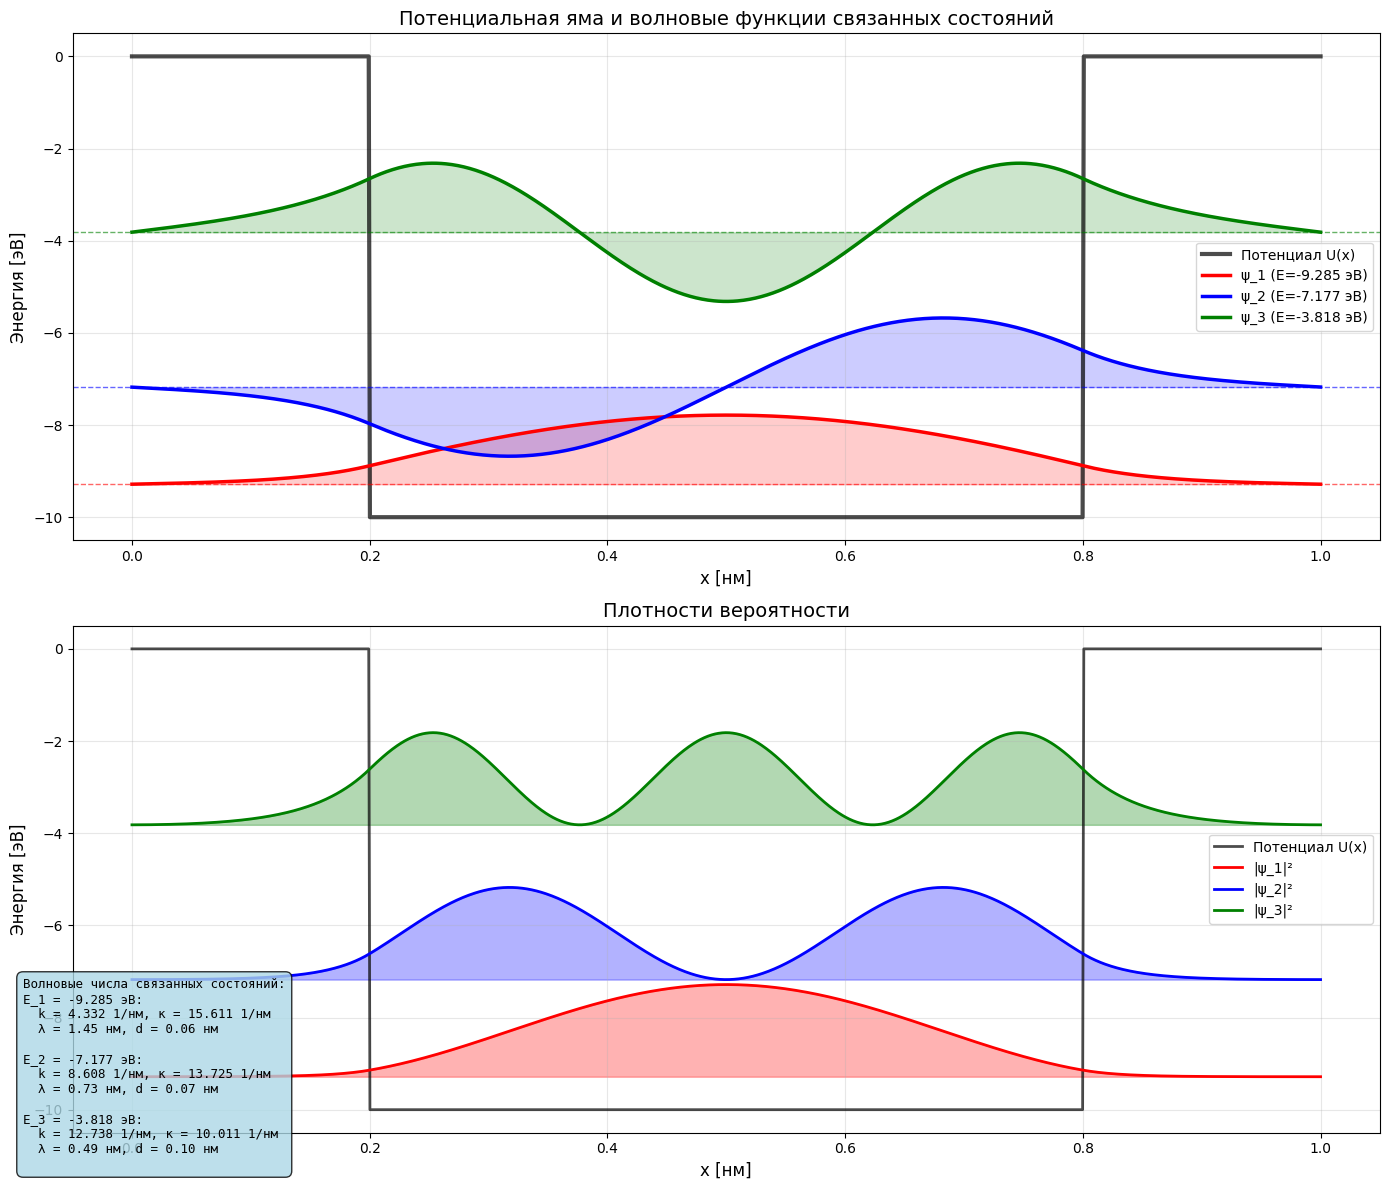

In [4]:
# Запуск конкретного примера
solver = rectangular_well()

In [5]:
# # Или запустить все примеры последовательно
# examples = [
#     rectangular_well,
#     parabolic_well, 
#     double_well,
#     arbitrary_well,
#     table_well
# ]

# print("ЗАПУСК ВСЕХ ПРИМЕРОВ:")
# for i, example in enumerate(examples):
#     print(f"\nПример {i+1}/{len(examples)}: {example.__name__}")
#     try:
#         solver = example()
#         print("\n" + "="*50 + "\n")
#     except Exception as e:
#         print(f"Ошибка в примере {example.__name__}: {e}")
#         continue